In [3]:
import pandas as pd
import csv
import os
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
import joblib

from sklearn.decomposition import PCA
import statsmodels.tools.tools as sm
from sklearn.metrics import confusion_matrix
from xgboost import XGBRegressor, XGBClassifier
from sklearn.ensemble import RandomForestClassifier
# from config import user_name,password

In [4]:
btc = pd.read_csv("../data/BTC-USD.csv")
btc = btc.drop(columns=["Adj Close","Open","High","Low","Volume"])
btc['Date']= pd.to_datetime(btc['Date'])
btc = btc.dropna()
btc_data = btc.iloc[::-1]
# btc_data.head()

In [5]:
btc_data = btc_data.rename(columns={'Close': 'Close_Btc'})
btc_data['Date'] = pd.to_datetime(btc_data['Date'])
btc_data['Day_Btc'] = btc_data['Date'].dt.day_name()
btc_data = btc_data.sort_values(by="Date")
# btc_data

In [6]:
btc_data_clean = btc_data.loc[((btc_data['Day_Btc'] != "Saturday") & (btc_data['Day_Btc'] != 'Sunday'))]
# btc_data_clean

In [7]:
btc_data_clean = btc_data_clean.drop(columns=["Day_Btc"])
btc_data_clean["BTC_Change%"] = btc_data_clean["Close_Btc"].pct_change()
btc_data_clean['BTC_Change%_lag'] = btc_data_clean["BTC_Change%"].shift(1)

# Construction direction of BITCOIN movement
btc_data_clean['BTC_dir'] = (btc_data_clean["BTC_Change%"]>0).astype(int)
btc_data_clean['BTC_dir_lag'] = btc_data_clean['BTC_dir'].shift(1)
# btc_data_clean

In [8]:
btc_data_clean.dtypes

Date               datetime64[ns]
Close_Btc                 float64
BTC_Change%               float64
BTC_Change%_lag           float64
BTC_dir                     int64
BTC_dir_lag               float64
dtype: object

In [9]:
eth = pd.read_csv("../data/ETH-USD.csv")
eth = eth.drop(columns=["Adj Close","Open","High","Low","Volume"])
eth['Date']= pd.to_datetime(eth['Date'])
eth_data = eth.dropna()
eth_data = eth_data.iloc[::-1]
eth_data.head()

,Date,Close
1826,2021-10-08,3597.323730
1824,2021-10-06,3580.562012
1823,2021-10-05,3518.518555
1822,2021-10-04,3380.089111
1821,2021-10-03,3418.358643


In [10]:
eth_data = eth_data.rename(columns={'Close': 'Close_Eth'})
eth_data['Date'] = pd.to_datetime(eth_data['Date'])
eth_data['Day_Eth'] = eth_data['Date'].dt.day_name()
eth_data = eth_data.sort_values(by="Date")
# eth_data

In [11]:
eth_data_clean = eth_data.loc[((eth_data['Day_Eth'] != "Saturday") & (eth_data['Day_Eth'] != 'Sunday'))]
# eth_data_clean

In [12]:
eth_data_clean = eth_data_clean.drop(columns=["Day_Eth"])
eth_data_clean["ETH_Change%"] = eth_data_clean["Close_Eth"].pct_change()
eth_data_clean['ETH_Change%_lag'] = eth_data_clean["ETH_Change%"].shift(1)

# Construction direction of Ethereum movement
eth_data_clean['ETH_dir'] = (eth_data_clean["ETH_Change%"]>0).astype(float)
eth_data_clean['ETH_dir_lag'] = eth_data_clean['ETH_dir'].shift(1)
eth_data_clean.head()

,Date,Close_Eth,ETH_Change%,ETH_Change%_lag,ETH_dir,ETH_dir_lag
2,2016-10-10,11.7555,NaN,NaN,0.0,NaN
3,2016-10-11,11.7857,0.002569,NaN,1.0,0.0
4,2016-10-12,11.9335,0.012541,0.002569,1.0,1.0
5,2016-10-13,11.9630,0.002472,0.012541,1.0,1.0
6,2016-10-14,11.9382,-0.002073,0.002472,0.0,1.0


In [13]:
eth_data_clean.dtypes

Date               datetime64[ns]
Close_Eth                 float64
ETH_Change%               float64
ETH_Change%_lag           float64
ETH_dir                   float64
ETH_dir_lag               float64
dtype: object

In [14]:
gold = pd.read_csv("../data/Gold-Futures.csv")
gold = gold.drop(columns=["Vol.","Change %","Open","High","Low"])
gold['Date']= pd.to_datetime(gold['Date'])
gold_data = gold.dropna()
# gold_data.head()

In [15]:
gold_data = gold_data.rename(columns={'Price': 'Price_Gold'})
gold_data['Date'] = pd.to_datetime(gold_data['Date'])
gold_data['Day_Gold'] = gold_data['Date'].dt.day_name()
gold_data = gold_data.sort_values(by="Date")
gold_data = gold_data.reset_index(drop=True)
gold_data['Price_Gold'] = gold_data.Price_Gold.str.replace(',', '').astype(float)
# gold_data

In [16]:
gold_data_clean = gold_data.loc[((gold_data['Day_Gold'] != "Saturday") & (gold_data['Day_Gold'] != 'Sunday'))]
# gold_data_clean

In [17]:
gold_data_clean = gold_data_clean.drop(columns=["Day_Gold"])
gold_data_clean["Gold_Change%"] = gold_data_clean["Price_Gold"].pct_change()
gold_data_clean['Gold_Change%_lag'] = gold_data_clean["Gold_Change%"].shift(1)

# Construction direction of GOLD movement
gold_data_clean['gold_dir'] = (gold_data_clean["Gold_Change%"]>0).astype(float)
gold_data_clean['gold_dir_lag'] = gold_data_clean['gold_dir'].shift(1)
gold_data_clean.head()

,Date,Price_Gold,Gold_Change%,Gold_Change%_lag,gold_dir,gold_dir_lag
0,2016-09-08,1400.2,NaN,NaN,0.0,NaN
1,2016-09-09,1393.1,-0.005071,NaN,0.0,0.0
2,2016-09-12,1384.4,-0.006245,-0.005071,0.0,0.0
3,2016-09-13,1380.8,-0.002600,-0.006245,0.0,0.0
4,2016-09-14,1383.3,0.001811,-0.002600,1.0,0.0


In [18]:
gold_data_clean.dtypes

Date                datetime64[ns]
Price_Gold                 float64
Gold_Change%               float64
Gold_Change%_lag           float64
gold_dir                   float64
gold_dir_lag               float64
dtype: object

In [19]:
snp = pd.read_csv("../data/S&P-500.csv")
snp = snp.drop(columns=["Vol.","Change %","Open","High","Low"])
snp['Date']= pd.to_datetime(snp['Date'])
snp_data = snp.dropna()
# snp_data.head()

In [20]:
snp_data = snp_data.rename(columns={'Price': 'Price_Snp'})
snp_data['Date'] = pd.to_datetime(snp_data['Date'])
snp_data['Day_Snp'] = snp_data['Date'].dt.day_name()
snp_data = snp_data.sort_values(by="Date")
snp_data = snp_data.reset_index(drop=True)
snp_data['Price_Snp'] = snp_data.Price_Snp.str.replace(',', '').astype(float)
# snp_data

In [21]:
snp_data_clean = snp_data.loc[((snp_data['Day_Snp'] != "Saturday") & (snp_data['Day_Snp'] != 'Sunday'))]
# snp_data_clean

In [22]:
snp_data_clean = snp_data_clean.drop(columns=["Day_Snp"])
snp_data_clean["Snp_Change%"] = snp_data_clean["Price_Snp"].pct_change()
snp_data_clean['Snp_Change%_lag'] = snp_data_clean["Snp_Change%"].shift(1)

# Construction direction of S&P movement
snp_data_clean['Snp_dir'] = (snp_data_clean["Snp_Change%"]>0).astype(float)
snp_data_clean['Snp_dir_lag'] = snp_data_clean['Snp_dir'].shift(1)
# snp_data_clean

In [23]:
usbond = pd.read_csv("../data/US-10-Year-Bond.csv")
usbond = usbond.drop(columns=["Change %","Open","High","Low"])
usbond['Date']= pd.to_datetime(usbond['Date'])
usbond_data = usbond.dropna()
# usbond_data.head()

In [24]:
usbond_data = usbond_data.rename(columns={'Price': 'Price_USB'})
usbond_data['Date'] = pd.to_datetime(usbond_data['Date'])
usbond_data['Day_USB'] = usbond_data['Date'].dt.day_name()
usbond_data = usbond_data.sort_values(by="Date")
usbond_data = usbond_data.reset_index(drop=True)
# usbond_data

In [25]:
usbond_data_clean = usbond_data.loc[((usbond_data['Day_USB'] != "Saturday") & (usbond_data['Day_USB'] != 'Sunday'))]
# usbond_data_clean

In [26]:
usbond_data_clean = usbond_data_clean.drop(columns=["Day_USB"])
usbond_data_clean["USB_Change%"] = usbond_data_clean["Price_USB"].pct_change()
usbond_data_clean['USB_Change%_lag'] = usbond_data_clean["USB_Change%"].shift(1)

# Construction direction of US BOND movement
usbond_data_clean['USB_dir'] = (usbond_data_clean["USB_Change%"]>0).astype(float)
usbond_data_clean['USB_dir_lag'] = usbond_data_clean['USB_dir'].shift(1)
# usbond_data_clean

In [27]:
usbond_data_clean.dtypes

Date               datetime64[ns]
Price_USB                 float64
USB_Change%               float64
USB_Change%_lag           float64
USB_dir                   float64
USB_dir_lag               float64
dtype: object

In [28]:
bit_1 = btc_data_clean.merge(eth_data_clean, how='left', on='Date')
# bit_1

In [29]:
bit_2 = bit_1.merge(snp_data_clean, how='left', on='Date')
# bit_2

In [30]:
bit_3 = bit_2.merge(usbond_data_clean, how='left', on='Date')
bit_3 = bit_3.dropna()
bit_3 = bit_3.reset_index(drop=True)
bit_3.head()

,Date,Close_Btc,BTC_Change%,BTC_Change%_lag,BTC_dir,BTC_dir_lag,Close_Eth,ETH_Change%,ETH_Change%_lag,ETH_dir,...,Price_Snp,Snp_Change%,Snp_Change%_lag,Snp_dir,Snp_dir_lag,Price_USB,USB_Change%,USB_Change%_lag,USB_dir,USB_dir_lag
0,2016-10-12,636.192017,-0.007612,0.035668,0,1.0,11.9335,0.012541,0.002569,1.0,...,2139.18,0.001147,-0.012447,1.0,0.0,1.771,0.002264,0.001133,1.0,1.0
1,2016-10-13,636.786011,0.000934,-0.007612,1,0.0,11.9630,0.002472,0.012541,1.0,...,2132.55,-0.003099,0.001147,0.0,1.0,1.746,-0.014116,0.002264,0.0,1.0
2,2016-10-14,640.377991,0.005641,0.000934,1,1.0,11.9382,-0.002073,0.002472,0.0,...,2132.98,0.000202,-0.003099,1.0,0.0,1.805,0.033792,-0.014116,1.0,0.0
3,2016-10-17,639.192993,-0.001850,0.005641,0,1.0,12.0050,0.005595,-0.002073,1.0,...,2126.50,-0.003038,0.000202,0.0,1.0,1.768,-0.020499,0.033792,0.0,1.0
4,2016-10-18,637.960022,-0.001929,-0.001850,0,0.0,12.5885,0.048605,0.005595,1.0,...,2139.60,0.006160,-0.003038,1.0,0.0,1.740,-0.015837,-0.020499,0.0,0.0


In [31]:
gold_1 = gold_data_clean.merge(usbond_data_clean, how='left', on='Date')
# gold_1

In [32]:
gold_2 = gold_1.merge(snp_data_clean, how='left', on='Date')
# gold_2

In [33]:
gold_3 = gold_2.merge(eth_data_clean, how='left', on='Date')
gold_3 = gold_3.dropna()
gold_3 = gold_3.reset_index(drop=True)
# gold_3.head()

In [34]:
bit_3 = bit_3[['Date', 'BTC_dir', 'BTC_dir_lag', 'BTC_Change%_lag', 'USB_Change%_lag',  'Snp_Change%_lag', 'ETH_Change%_lag']]
bit_3.head()

,Date,BTC_dir,BTC_dir_lag,BTC_Change%_lag,USB_Change%_lag,Snp_Change%_lag,ETH_Change%_lag
0,2016-10-12,0,1.0,0.035668,0.001133,-0.012447,0.002569
1,2016-10-13,1,0.0,-0.007612,0.002264,0.001147,0.012541
2,2016-10-14,1,1.0,0.000934,-0.014116,-0.003099,0.002472
3,2016-10-17,0,1.0,0.005641,0.033792,0.000202,-0.002073
4,2016-10-18,0,0.0,-0.001850,-0.020499,-0.003038,0.005595


In [35]:
# gold_plot = gold_3[["Date","gold_dir"]]
# gold_plot.to_csv("gold_plot.csv",index=False)

In [36]:
train = bit_3.iloc[:-100, :]
test = bit_3.iloc[-100:, :]
train.tail(), test.head()

x_train = train[['BTC_dir_lag', 'BTC_Change%_lag',  'USB_Change%_lag',  'Snp_Change%_lag', 'ETH_Change%_lag']]
y_train = train['BTC_dir']
x_test = test[['BTC_dir_lag', 'BTC_Change%_lag',  'USB_Change%_lag',  'Snp_Change%_lag', 'ETH_Change%_lag']]
y_test = test['BTC_dir']

# x_train, y_train

In [37]:
# Logistic Model specification
logit = LogisticRegression()                                                 

days_logit = 70
    # Note: 54.55% accuracy  [[22 41] [19 50]]

# Making predictions for only latest 132 days
buffer = 132

# for days_logit in range(20, 910, 10):
pred_logit = pd.DataFrame(columns=['Date', 'BTC_dir','logit_pr']) # DataFrame to store logit outcome

data_log = bit_3.iloc[-days_logit-buffer:]  

for j in range(0, buffer):

    train = data_log.iloc[j:j+days_logit,:] # Training Model    
    test = data_log.iloc[j+days_logit : j+days_logit+1,:] # Testing Model

    # Separating X and Y variables for easy computation
    x_train = train.drop(columns=['Date', 'BTC_dir'])        
    x_test = test.drop(columns=['Date', 'BTC_dir'])

    y_train = train['BTC_dir']
    y_test = test['BTC_dir']

    selector = RFECV(estimator=logit, cv=5, step=1)
    selector.fit(x_train, y_train)
    features_bit = x_train.columns.tolist()
    selected_features_bit = sorted(zip(selector.ranking_, features_bit))
    features_rank_bit = pd.DataFrame(selected_features_bit, columns=['Ranking', 'Feature'])
    features_rank_bit = features_rank_bit.set_index('Feature')
#         print(features_rank_bit)

    ranked_features_bit = []
    for s in selected_features_bit:
        if s[0] < 3:
            ranked_features_bit.append(s[1])

    x_train_bit_sel = x_train[ranked_features_bit]
    x_test_bit_sel = x_test[ranked_features_bit]

    logit_model = logit.fit(x_train_bit_sel, y_train) 
    y_pred_l = logit_model.predict_proba(x_test_bit_sel)[:,1]
#     print(logit_model.predict(x_test_bit_sel), y_pred_l)

    df_reg = pd.DataFrame({'logit_pr':y_pred_l.tolist()})
    true_data = test[['Date', 'BTC_dir']]
    true_data = true_data.reset_index().drop(columns=['index'])
    df = pd.concat([true_data, df_reg], axis=1)
    pred_logit = pred_logit.append(df)  #Appending predictions to DF
    

for i in range(1, pred_logit.shape[1]):
    pred_logit.iloc[:,i] = pred_logit.iloc[:,i].astype(float);

# a_logit = confusion_matrix(pred_logit['BTC_dir'], pred_logit['logit'])
# b_logit = round((a_logit[0][0] + a_logit[1][1])/(a_logit[0][0]+ a_logit[1][1] + a_logit[0][1] + a_logit[1][0]), 4)
# print('day_logit:', days_logit, '\n', a_logit, b_logit)

In [38]:
pred_logit

,Date,BTC_dir,logit_pr
0,2021-03-31,1.0,0.578388
0,2021-04-01,1.0,0.577466
0,2021-04-05,0.0,0.578239
0,2021-04-06,0.0,0.675567
0,2021-04-07,0.0,0.644079
...,...,...,...
0,2021-09-30,1.0,0.571007
0,2021-10-01,1.0,0.585426
0,2021-10-04,1.0,0.589372
0,2021-10-05,1.0,0.585752


### XG Boost

In [39]:
days_xg = 90
    # Note: 60.61% accuracy  [[35 28] [24 45]]

# for days_xg in range(10, 910,10):
pred_xgb_r = pd.DataFrame(columns=['Date', 'BTC_dir', 'xg_bit_pr'])

data_xg = bit_3.iloc[-days_xg-buffer:, :]

for i in range(0, buffer):
    train = data_xg.iloc[i:days_xg+i, :] # Training model
    test = data_xg.iloc[days_xg+i : days_xg+i+1, :]
#     print(train.tail(2), test)

    x_train = train.drop(columns=['BTC_dir', 'Date'])
    y_train = train['BTC_dir']

    x_test = test.drop(columns=['BTC_dir', 'Date'])
    y_test = test['BTC_dir']

    xg_m = XGBRegressor()
    xg_m2 = xg_m.fit(x_train, y_train)
    y_pred_xg = xg_m2.predict(x_test)

    df_reg = pd.DataFrame({'xg_bit_pr': y_pred_xg.tolist()})
    true_data = test[['Date', 'BTC_dir']]
    true_data = true_data.reset_index(drop=True)

    df = pd.concat([true_data, df_reg], axis=1)
    pred_xgb_r = pred_xgb_r.append(df)    

pred_xgb_r['xg_bit_pr'] = np.where(pred_xgb_r['xg_bit_pr']>1, 1, np.where(pred_xgb_r['xg_bit_pr']<0, 0, pred_xgb_r['xg_bit_pr']))

In [40]:
pred_xgb_r.describe()

,xg_bit_pr
count,132.000000
mean,0.526964
std,0.321897
min,0.000000
25%,0.236864
50%,0.562281
75%,0.792734
max,1.000000


In [41]:
# XGB Classifier

days_xg = 80

# for days_xg in range(10, 910,10):
pred_xgb_c = pd.DataFrame(columns=['Date', 'BTC_dir', 'xg_bit_c_pr'])

data_xg = bit_3.iloc[-days_xg-buffer:, :]

for i in range(0, buffer):
    train = data_xg.iloc[i:days_xg+i, :] # Training model
    test = data_xg.iloc[days_xg+i : days_xg+i+1, :]
#     print(train.tail(2), test)

    x_train = train.drop(columns=['BTC_dir', 'Date'])
    y_train = train['BTC_dir']

    x_test = test.drop(columns=['BTC_dir', 'Date'])
    y_test = test['BTC_dir']

    xg_m = XGBClassifier()
    xg_m2 = xg_m.fit(x_train, y_train)
    y_pred_xg = xg_m2.predict_proba(x_test)[:,1]

    df_reg = pd.DataFrame({'xg_bit_c_pr': y_pred_xg.tolist()})
    true_data = test[['Date', 'BTC_dir']]
    true_data = true_data.reset_index(drop=True)

    df = pd.concat([true_data, df_reg], axis=1)
    pred_xgb_c = pred_xgb_c.append(df)    
    
pred_xgb_c.head()

/Users/jsb/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:56:22] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:56:22] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:56:22] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

[15:56:23] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:56:23] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:56:23] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

[15:56:24] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:56:24] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:56:24] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

[15:56:25] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:56:25] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:56:25] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

[15:56:25] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:56:25] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:56:25] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

,Date,BTC_dir,xg_bit_c_pr
0,2021-03-31,1,0.073877
0,2021-04-01,1,0.421424
0,2021-04-05,0,0.080698
0,2021-04-06,0,0.962441
0,2021-04-07,0,0.239045


# Random Forest

In [42]:
pred_xgb_c.describe()

,xg_bit_c_pr
count,132.000000
mean,0.525250
std,0.351043
min,0.012286
25%,0.160305
50%,0.502186
75%,0.886573
max,0.996504


In [43]:
days_rf = 370
rs_start = 4
rs_end = 5

# for days_rf in range(10,910, 10):
pred_rf = pd.DataFrame(columns=['Date', 'BTC_dir', 'rs', 'rf_pr'])
data_rf = bit_3.iloc[-days_rf-buffer:, :]

for rs in range(rs_start, rs_end):   # Various random states
    for i in range(0, buffer):
        train = data_rf.iloc[i:days_rf+i, :] # Training model
        test = data_rf.iloc[days_rf+i : days_rf+i+1, :]
#             print(train.tail(2), test)

        # Separating X and Y variables for easy computation
        X_train = train.drop(columns=['Date', 'BTC_dir'])
        X_test = test.drop(columns=['Date', 'BTC_dir'])

        y_train = train['BTC_dir']
        y_test = test['BTC_dir']

        pca = PCA(n_components = 0.95).fit(X_train) # Principal Component Analyses

        train_pca = pca.transform(X_train)
        test_pca = pca.transform(X_test)

        # Random Forest Model
        random_forest = RandomForestClassifier(oob_score= False, n_estimators= 50, min_samples_split= 2, max_features= 'log2',
                                criterion= 'gini', bootstrap= True, random_state=rs)
#             random_forest = RandomForestClassifier()
        rf_model = random_forest.fit(train_pca, y_train) 
        y_pred_rf = rf_model.predict_proba(test_pca)[:,1]

        ls_rs = [rs]*len(y_test)

        df_reg = pd.DataFrame({'rs': ls_rs, 'rf_pr': y_pred_rf.tolist()})
        true_data = test[['Date', 'BTC_dir']]
        true_data = true_data.reset_index().drop(columns=['index'])
        df = pd.concat([true_data, df_reg], axis=1)
        pred_rf = pred_rf.append(df)
#             print(pred_rf.tail(2))

    # Retaining only that random state with highest accuracy      
    for i in range(1, pred_rf.shape[1]): # The outputs may come in str type  
        pred_rf.iloc[:,i] = pred_rf.iloc[:,i].astype(float)

    # Estimating Confusion matrix for each model and random state
# cm = pd.DataFrame(columns=['rs', 'RF_CM', 'RF_Accuracy'])

# for rs in range(rs_start, rs_end):
#     df = pred_rf[pred_rf['rs']==rs]
#     a_rf = (confusion_matrix(df['BTC_dir'], df['rf']))
#     b_rf = round((a_rf[0][0] + a_rf[1][1])/(a_rf[0][0]+ a_rf[1][1] + a_rf[0][1] + a_rf[1][0]),4) 
#     conf_mat = pd.DataFrame({'rs': [rs], 'RF_CM': [a_rf], 'RF_Accuracy': [b_rf]}) # Appending to dataframes element-wise
#     cm = cm.append(conf_mat)


# max_acc_rs = cm['rs'][cm['RF_Accuracy']==cm['RF_Accuracy'].max()] # Retaining obs with highest accuracy
# pred_rf_max_acc = pred_rf[pred_rf['rs']==max_acc_rs.iloc[0]]
# print('days_rf:', days_rf, cm[cm['rs']==max_acc_rs.iloc[0]])

pred_rf_max_acc = pred_rf

In [44]:
# pred_rf_max_acc.head()
pred_rf_max_acc.describe()

,BTC_dir,rs,rf_pr
count,132.000000,132.0,132.000000
mean,0.522727,4.0,0.538636
std,0.501386,0.0,0.347160
min,0.000000,4.0,0.000000
25%,0.000000,4.0,0.195000
50%,1.000000,4.0,0.640000
75%,1.000000,4.0,0.860000
max,1.000000,4.0,1.000000


In [45]:
trading_pr_b = pred_logit.merge(pred_xgb_r, on=['Date', 'BTC_dir'], how='inner')
trading_pr_b = trading_pr_b.merge(pred_xgb_c, on=['Date', 'BTC_dir'], how='inner')
trading_pr_b = trading_pr_b.merge(pred_rf_max_acc, on=['Date', 'BTC_dir'], how='inner')
trading_pr_b = trading_pr_b.drop(columns=['rs'])
trading_pr_b.head()

,Date,BTC_dir,logit_pr,xg_bit_pr,xg_bit_c_pr,rf_pr
0,2021-03-31,1,0.578388,0.007860,0.073877,0.60
1,2021-04-01,1,0.577466,0.712583,0.421424,0.26
2,2021-04-05,0,0.578239,0.238035,0.080698,0.16
3,2021-04-06,0,0.675567,0.609019,0.962441,0.68
4,2021-04-07,0,0.644079,0.448535,0.239045,0.90


In [46]:
trading_pr_b.to_csv("prob_b.csv", index=False)

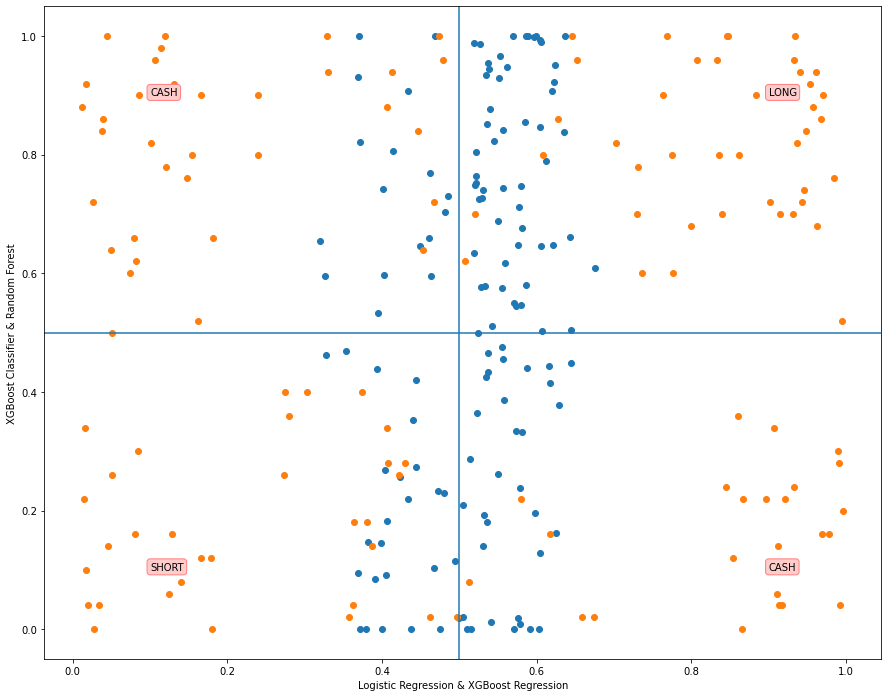

In [60]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 12))
plt.scatter(trading_pr_b['logit_pr'], trading_pr_b['xg_bit_pr'])
plt.scatter(trading_pr_b['xg_bit_c_pr'], trading_pr_b['rf_pr'])
# plt.vlines(0.5,linestyles='solid')
plt.axvline(x=0.5)
plt.axhline(y=0.5)
plt.text(0.9, 0.9, 'LONG', bbox=dict(boxstyle="round", ec=(1., 0.5, 0.5), fc=(1., 0.8, 0.8),))
plt.text(0.1, 0.1, 'SHORT', bbox=dict(boxstyle="round", ec=(1., 0.5, 0.5), fc=(1., 0.8, 0.8),))
plt.text(0.1, 0.9, 'CASH', bbox=dict(boxstyle="round", ec=(1., 0.5, 0.5), fc=(1., 0.8, 0.8),))
plt.text(0.9, 0.1, 'CASH', bbox=dict(boxstyle="round", ec=(1., 0.5, 0.5), fc=(1., 0.8, 0.8),))
plt.xlabel("Logistic Regression & XGBoost Regression")
plt.ylabel("XGBoost Classifier & Random Forest")
plt.savefig('bitcoin.png')
plt.show()
